# Lab1 - Time Domain Lab

This week we will interact with physical time-domain signals. The first task will involve generating and recording sounds on your computer. 
In the second we will use the computer sound system as a simple sonar. The last task will involve sampling the Automatic Dependent Survaillance Broadcast (ADS-B) frequency band (around 1090MHz) using the rtl-sdr and looking at packets sent from airplanes in the bay area. 

In [1]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal

# Task II
import threading,time

# Task IV
from rtlsdr import RtlSdr
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
%matplotlib inline

ModuleNotFoundError: No module named 'pyaudio'

## Part 1: Chirping

For this assignment you will have to use iPython, and a laptop equipped with a speaker and a microphone. When playing a sound and recording on the computer speaker, the signal goes through several systems. In particular it goes through the response of the speaker, the room we are in and the response of the microphone recording system.

A chirp is a a signal in which the frequency increases linearly with time. In this assignment we will generate a chirp signal and use it to measure the amplitude of the frequency response of our speaker-room-microphone system.

A simultaneous frequency is defined as the derivative of the phase of a signal, $f = \frac{d\phi (t)}{2\pi dt} $. For example, the simultanious frequency of $cos(\phi(t))=cos(2\pi f_0 t)$ is $f = \frac{d\phi (t)}{2\pi dt}  = f_0$. 


For a linear chirp, the frequency changes linearly over time. The simultaneous frequency is therefore defined as 

<center>$$ f(t) = f_0 + kt. $$</center>


So,  

<center>$$ x(t) = \sin(2\pi\int_0^t f(t')dt') = \sin(2\pi\int_o^t(f_0+kt')dt') = \sin(2\pi(f_0+\frac{k}{2}t)t) $$</center>


###Task I:
Generate a 15 seconds long chirp signal, sampled at 44,100[Hz] with a frequency range of 20[Hz] to 20000[Hz]. Set the magnitude of the chirp to 0.5. This will help prevent non-linearities when we play the sound later. 


1.  Set the sample-rate frequency fs = 44100 Hz
2.  Generate a time index from t=0 to t=15 with sampling rate of 44100 Hz
3.  Generate a vector of frequency vs time: f_of_t ($f(t)$) that changes linearly from 20Hz to 20Khz over 15 seconds
4.  Generate a vector of phase vs time: phi_of_t ($\phi(t) = 2\pi \int_0^t f(t)dt$) by numerically integrating f_of_t. You will find the function `np.cumsum` useful.
5.  Generate the chirp function with amplitude of 0.5
  
  


In [1]:
fs = 44100
# generate time index
t = r_[0.0:15*fs:1.0]/fs

# generate chirp signal
f_of_t = 20.0 + t/15.0*(20000.0-20.0)
phi_of_t = 2*pi*np.cumsum(f_of_t)/fs
s_chirp = sin( phi_of_t ) * 0.5

* Plot the first $\frac{1}{2}$ a second of the chirp, you will notice that the carrier frequency increases and that the chirp has a constant envelope. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately.

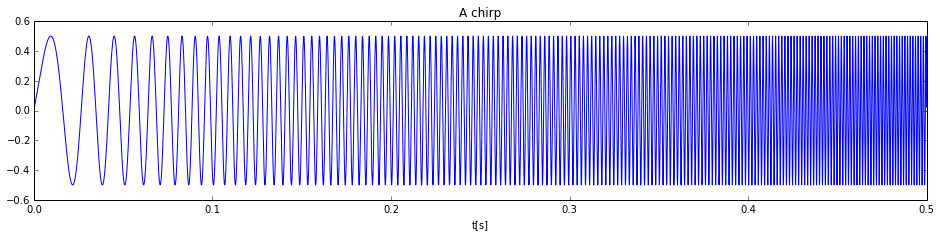

In [7]:
# Set the aspect ratio such that the image is wide
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))

#Your code below:
plt.plot(t[0:fs/2], s_chirp[0:fs/2])
plt.xlabel('t[s]')
plt.title( 'A chirp' )


* Plot the magnitude frequency response of the sequence from 0 to $\pi$ using the function `signal.freqz`. Note, that the digital frequency range represents a physical frequency range of 0[hz] to 22050[Hz]. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately.


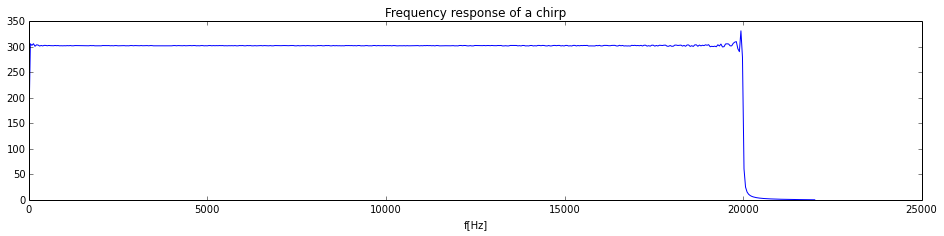

In [10]:
# Your code below:

# generate frequency response of chirp
w, S_chirp = signal.freqz(s_chirp,1,worN=512)

# generate frequency index
f = r_[0.0:512.0] / 512.0 * fs / 2.0


width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(f, abs(S_chirp))
plt.xlabel('f[Hz]')
plt.title( 'Frequency response of a chirp' )

* Explain why the chirp is an appropriate signal to measure the magnitude frequency response of a system. 


#### Your answer here:
A linear chirp sweeps all frequencies and therefore has uniform magnitude frequency response, much like the impulse function. The magnitude of the DTFT of the output of the signal will only be weighted by the frequency response of the system
* * *

###Task II:
Now, we will play the sound of the chirp on our computer speaker and simultaneously record using the microphone. 

* On an Apple computers it is recommended that you turn off the ambient noise reduction by going to system-preferences, selecting sound, choose the input tab and make sure that the "Use ambient noise reduction" box is unchecked. In some windows system there's ambient noise reduction as well. Make sure it is also turned off. 

* Your laptop most likely has two speakers. It is best if we work only with one. Go to the operating system's sound settings and change the stereo settings such that the speaker that is closest to the microphone is active. Your result will be much better that way. 
		
* Make sure your output volume is at 70-80% and that the laptop's microphone is on, again to avoid non-linear distorsions. 

* We will record 17 seconds just to make sure we capture the entire sequence. 

The code below defines some functions to use with pyaudio -- a multi-platform audio python interface. 

In [32]:

import numpy as np
import threading,time
import pyaudio

## Define functions that play and record audio

def play_audio( data, p, fs):
    # play_audio plays audio with sampling rate = fs
    # data - audio data array
    # p    - pyAudio object
    # fs    - sampling rate
    # 
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # play_audio( data, p, fs ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True)
    # play audio
    ostream.write( data.astype(np.float32).tostring() )
    
    
def record_audio( odata, p, fs, record_seconds ):
    # record_audio records audio with sampling rate = fs
    # odata - output data
    # p     - pyAudio object
    # fs    - sampling rate
    # record_seconds - record seconds
    #
    # Example:
    # fs = 44100
    # record_seconds = 5
    # odata = zeros( fs * record_seconds ) # initialize odata
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( odata, p, fs, record_seconds ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open input stream
    chunk = 1024
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    for i in range(0, int(fs / chunk * record_seconds)):
        data_str = istream.read(chunk) # read a chunk of data
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        frames.append( data_flt ) # append to list
        
    # flatten list to array
    data = np.concatenate( frames )
    # copy to output
    np.copyto(odata[0:len(data)], data)


#### playing and recording audio:
Run the following code. It is an example how to play and record sound at the same time and uses threading for the play and record threads.

The resulting received sequence will be stored in the variable `rcv_chirp`.

In [33]:
## Play and record chirp at the same time

RECORD_SECS = 17 # record 10 seconds

# allocate receive chirp response
rcv_chirp = zeros( RECORD_SECS * fs );

# instantiate PyAudio
p = pyaudio.PyAudio()

# initialize threads
t_play = threading.Thread(   target = play_audio,   args = (s_chirp,   p, fs,  ))
t_record = threading.Thread( target = record_audio, args = (rcv_chirp, p, fs, RECORD_SECS , ))

# start recording and playing threads at the same time
t_record.start()
t_play.start()

# pause for  seconds
time.sleep( RECORD_SECS +1)

# terminate pyAudio
p.terminate()


* Plot the frequency response of the received sequence. 
* Also, plot the absolute value of the received signal. Plotting the absolute value (sort of) displays the envelope of the chirp. 

Label the figures and use an aspect ration of Height/Width = 0.2


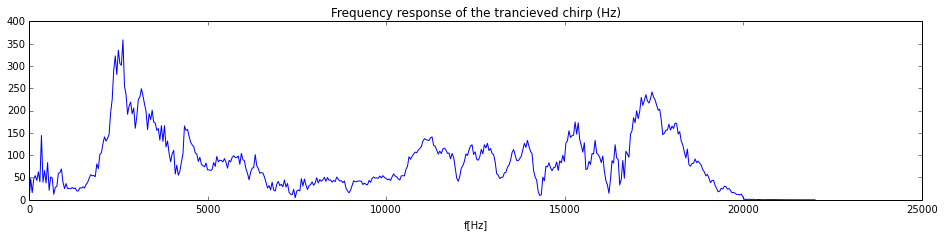

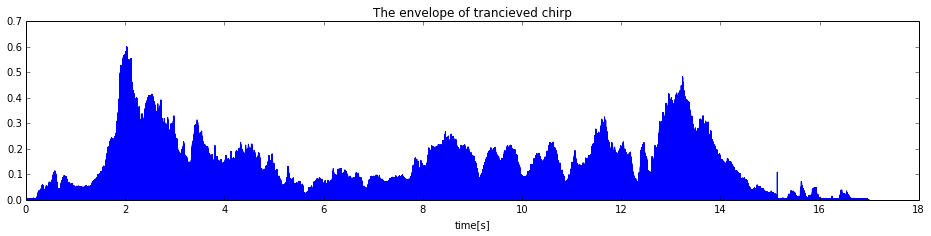

In [34]:
## Plot chirp response
# Your code below:

# generate frequency response of chirp
w, RCV_chirp = signal.freqz(rcv_chirp)

# generate frequency index
f = r_[0.0:512.0] / 512.0 * fs / 2.0


width, height = figaspect(0.2)
fig1 = figure(figsize=(width,height))
plt.plot(f, abs( RCV_chirp ) )
plt.title('Frequency response of the trancieved chirp (Hz)')
plt.xlabel('f[Hz]')
fig1 = figure(figsize=(width,height))
plt.plot( r_[0.:len(rcv_chirp)/fs:1./fs], abs(rcv_chirp))
#axis([0,17,0,max(abs(rcv_chirp))/10])
plt.title('The envelope of trancieved chirp');
plt.xlabel('time[s]')



* Comment on the results you got. In addition, what is the implicit assumption we are making in order to claim that the result is a frequency response? 
(HINT: consider the case when the chirp was very short)

#### Answers here:
What is interesting is that the time response of the chirp is similar to the frequency response. This makes perfect sense, since for a chirp, frequency is dependent on time. The implicit assumtion that we are making is that the time effect in the room are much faster than the sweep of the chirp, so for each frequency we get the steady-state response. If the chirp was much faster, we would have seen echoes coming back from reflecting surfaces, which will show up at a different time. So time would not necessarily purely correspond to frequency.

#### Envelope detection with Hilbert transform. 
The absolute value of the of the result "sort of" display the envelope, however it still modulated by the (now rectified) frequency sweep carrier. If we write down the response, it can be expressed approximately as $$y[n] = |H[n]|sin(2\pi (f_0 +k[n*T])nT + \angle H[n])$$,
where $|H[n]|$ is the frequency response for the instantaniouse frequency at the nth sample and $\angle H[n]$ is its phase response. 
The reason that it is only approximate is that there is an inherent assumption that we do not look at transient effects, only steady state effect for each frequency. This is a good approximation because our chirp is very slow compared to the propagation of sound in the room. 

One way to get the envelope |H[n]| is to convert it to its analytic signal. The analytic signal $x_a(t)$ of signal $x(t)$ is:
$$x_a = F^{-1}(F(x)\cdot 2U) = x + j y$$
where $F$ is the Fourier transform, $U$ the unit step function,
and $y$ the Hilbert transform of $x$. In other words, the negative half of the frequency spectrum is zeroed
out, turning the real-valued signal into a complex signal. This is similar to the question in HW2!

The analytic signal of the received chirp will then be: 
$$ y_a[n] = |H[n]|e^{j2\pi (f_0 +k[n*T])nT + \angle H[n]} $$. 
The envelope can be detected by taking the magnitude. 

Task: Compute the analytic signal by using the function `signal.hilbert` and plot its absolute value. Note that the discrete hilbert transform is not perfect, since it uses FIR filtering. This will show up as ripple in the envelope.

Label the figures and use an aspect ration of Height/Width = 0.2



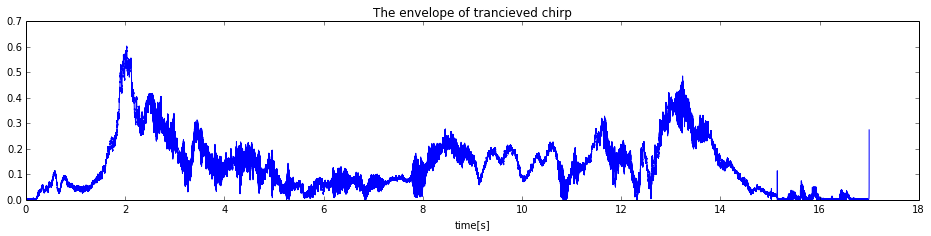

In [35]:
rcv_chirp_a = signal.hilbert(rcv_chirp)
fig1 = figure(figsize=(width,height))
plt.plot( r_[0.:len(rcv_chirp_a)/fs:1./fs], abs(rcv_chirp_a))
#axis([0,17,0,max(abs(rcv_chirp))/10])
plt.title('The envelope of trancieved chirp');
plt.xlabel('time[s]')

### Task III: 
The chirp has a very nice property that its auto-correlation is very narrow. A discrete autocorrelation of a signal is defined as: 
$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 
It is basically a cross correlation of the signal with itself. A cross correlation is defined as:
$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = (x[m]*y^*[-m])[n]$$ 
This property is called pulse compression and is used widely in radar. Random noise and some other pseudo-random like sequences also posseses this property. 

* Generate a 512 sample chirp pulse with a frequency sweep from 17KHz-19KHz and sampling rate fs=44100. 
* Validate its frequency response by plotting it.

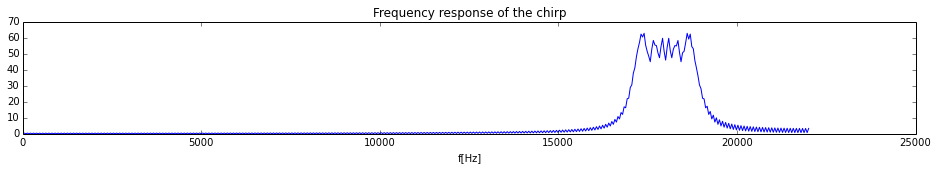

In [9]:
## Your beautiful code here:

fs = 44100
t = r_[0.0:512]/fs

f0 = 17000.0
f1 = 19000.0
# generate chirp signal
f_of_t =  f0 + t*fs/512.0*(f1-f0)
phi_of_t = 2*pi*np.cumsum(f_of_t)/fs
s_chirp = sin( phi_of_t )

# generate frequency response of chirp
w, S_chirp = signal.freqz(s_chirp,1,worN=512)
# generate frequency index
f = r_[0.0:512.0] / 512.0 * fs / 2.0
width, height = figaspect(0.1)
fig = figure(figsize=(width,height))
plt.plot(f, abs(S_chirp))
plt.xlabel('f[Hz]')
plt.title( 'Frequency response of the chirp' )

* Compute the autocorrelation of the chirp discrete convolution, either with `signal.convolve` or `signal.fftconvolve`. Remember that you have to flip the signal since convolution does that already. Use mode=''full''
* plot the autocorrelation

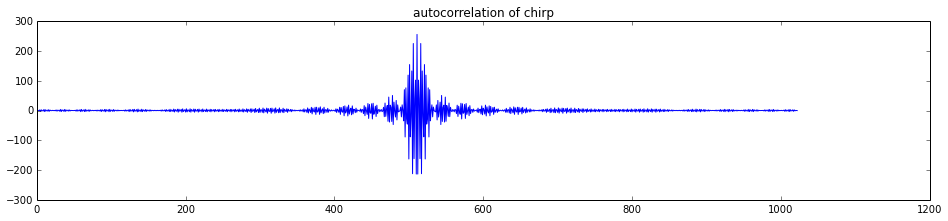

In [10]:
chirp_acorr = signal.fftconvolve(s_chirp,s_chirp[::-1],mode="full")

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot((chirp_acorr))
plt.title( 'autocorrelation of chirp' )


In a similar way as we did before, it is possible to recover the envelope of the autocorrelation by performing a cross-correlation with the analytic signal and then taking the absolute value. In this case, we know exactly what is the analytic function is!

* Generate s_chirp_a, the analytic function of the chirp by computing: `s_chirp_a = exp(1j* phi_of_t )`. Perform the cross correlation and show the envelope. This is also called a matched filter. 
* Comment on the size of the main lobe of the matched-filter with respect to the size of the cross-correlation. 

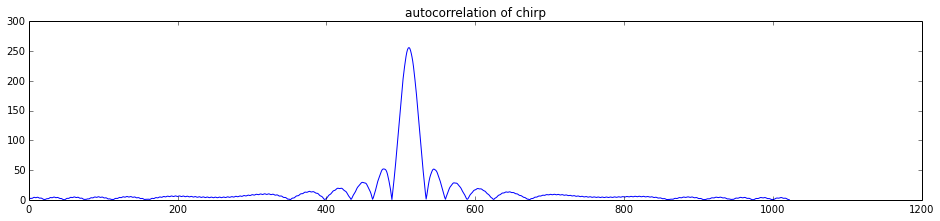

In [11]:
## your code here
s_chirp_a = exp( 1j * phi_of_t )
chirp_acorr = signal.convolve(s_chirp,conj(s_chirp_a[::-1]))

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(abs(chirp_acorr))
plt.title( 'autocorrelation of chirp' )



#### Your answer here:

- Repeat Task III for:
 1. A constant frequency of 19000Hz, 512 samples in length. 
 2. A chirp with a frequency sweep from 15000Hz - 20000Hz, 512 in length. 

- Compare the size of the main lobes. How much "Pulse Compression" are you getting by using a chirp for detection compared to a single frequency pulse?

In [39]:
# your solution here

#### Your answers and interpretations here:

#### Dealing with sidelobes
As you can see, the chirp provides good pulse compression of the main-lobe. However, there are very strong sidelobes. This is because the chirp is multiplied with a rect function, that is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes. 
    
* Repeat the task above for a chirp with a sweep from 17KHz to 19KHz. This time, multiply the chirp (and its analytic function) with the square-root of the hamming window.  You will find the function `np.hamming` useful. The reason for using a square root is that when performing the matched filtering will result in squaring of the frequency response of the result, which gives a multiplication with the window, rathern than squared function of the window. 

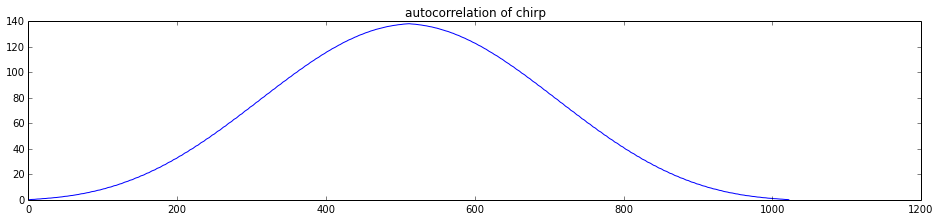

In [6]:
# your solution here

f0 = 3000.0
f1 = 3000.0
fs = 44100
t = r_[0.0:512]/fs

# generate chirp signal
f_of_t =  f0 + t*fs/512.0*(f1-f0)
phi_of_t = 2*pi*np.cumsum(f_of_t)/fs
s_chirp = sin( phi_of_t )*sqrt(np.hamming(512))
s_chirp_a = exp( 1j * phi_of_t )*sqrt(np.hamming(len(s_chirp)))

chirp_acorr = signal.convolve(s_chirp,conj(s_chirp_a[::-1]))

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(abs(chirp_acorr))
plt.title( 'autocorrelation of chirp' )

### You are now ready to proceed to the Sonar Lab